# Comparing the Two Multislice Functions

1. Chromatix Pipeline Multislice: simulate_multislice_chromatix()
2. Iteratively Applying the Projection Approximation: simulate_multislice_PA()

The two functions should both produce the same result when done correctly. However, currently (01/31/25) the second multislice function (_PA) produces correct results (significantly different from the projection approximation as expected) while the first multislice function (_chromatix) produces incorrect results, namely little to virtually no difference between the multislice and the actual projection approximation.

### Prelims

In [11]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import jax
import jax.numpy as jnp

from src.spectral_xpci.xscatter import get_delta_beta_mix
from src.spectral_xpci.simulate import get_wavelen, apply_psf, simulate_projection
from chromatix.ops import init_plane_resample
import chromatix.functional as cx

from multislice import Material, make_fiber_phantom

In [12]:
pmma = Material('PMMA', 'H(8.06)C(59.98)O(31.96)', 1.19)
nylon = Material('nylon', 'H(9.7980)C(63.6853)N(12.3779)O(14.1388)', 1.15)
glass = Material('glass', 'O(53.9559)Na(2.8191)Al(1.1644)Si(37.7220)K(0.3321)', 2.230)
breast = Material('breast tissue', 'C(33.2)N(3.0)O(52.7)Na(0.1)P(0.1)S(0.2)Cl(0.1)', 1.02)

plt.rcParams.update({
    'figure.dpi': 150,
    'font.size':10,
    'axes.titlesize':10,
    'axes.labelsize':8,
    'axes.linewidth': .5,
    'xtick.top': True, 
    'ytick.right': True, 
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'xtick.labelsize':8,
    'ytick.labelsize':8,
    'legend.fontsize': 8,
    'lines.linewidth':1,
    'image.cmap':'gray'
    })

def add_scalebar(ax, sz, Nx, real_dx, real_units, color='k'):
    width_px = sz * Nx 
    label = f'{real_dx * width_px:.0f} {real_units}'
    scalebar = AnchoredSizeBar(ax.transData, width_px, label, 'lower left', size_vertical=1, frameon=False, color=color)
    ax.add_artist(scalebar)

def im_min(im1, im2):
    return min(np.min(im1), np.min(im2))

def im_max(im1, im2):
    return max(np.max(im1), np.max(im2))

def NF(a, E, z):  
    """Fresnel number"""
    return a**2 / (get_wavelen(E)*z)

### The Two Functions:

In [13]:
def simulate_multislice_chromatix(obj_beta, obj_delta, phantom_dx, phantom_dz, phantom_N, z_slices, 
                                    det_shape, det_dx, det_fwhm, energy, propdist, I0):
    # from multislice.ipynb
    # this is the one that needs to be fiddled with to get the right output

    # cailey added this line to troubleshoot / generalize
    # note that cailey also added the function input parameters "phantom_N, z_slices" above
    phantom_shape = jnp.array([z_slices, phantom_N, phantom_N])

    field = cx.plane_wave(
        shape = phantom_shape[1:], 
        dx = phantom_dx,
        spectrum = get_wavelen(energy),
        spectral_density = 1.0,
    )

    field = field / field.intensity.max()**0.5 / ((phantom_N / det_shape[0])**2)  # normalize
    cval = field.intensity.max()

    
    # modulate field thru sample
    exit_field = cx.multislice_thick_sample(field, obj_beta, obj_delta, n_avg, phantom_dz, N_pad)
    
    # propagate thru free space to the detector
    det_field = cx.transfer_propagate(exit_field, propdist, n_medium, N_pad, cval=cval, mode='same')
    
    # resample from phantom resolution -> detector resolution (pixel sizes don't necessarily match)
    det_resample_func = init_plane_resample(det_shape, (det_dx, det_dx), resampling_method='linear')
    img_ms = det_resample_func(det_field.intensity.squeeze()[...,None,None], field.dx.ravel()[:1])[...,0,0]
    # img_ms /= img_ms.ravel()[0] 
    # better normalization here! 
    
    # add noise and PSF blur
    img_ms = jax.random.poisson(key, I0*img_ms, img_ms.shape) / I0 # noise
    img_ms = apply_psf(img_ms, fov, det_dx, psf=det_psf, fwhm=det_fwhm, kernel_width=0.1)

    return img_ms

In [14]:
def simulate_multislice_PA(obj_beta, obj_delta, phantom_dx, phantom_dz, phantom_N, z_slices, 
                        det_shape, det_dx, det_fwhm, energy, propdist, I0,
                        det_psf='lorentzian', N_pad=100, n_medium=1, n_avg=1, key=jax.random.PRNGKey(3),
                        dzlist=None):
    # from multislice.py
    # this is the correct output used in AAPM 2025
    
    phantom_shape = jnp.array([z_slices, phantom_N, phantom_N])

    field = cx.plane_wave(
        shape = phantom_shape[1:], 
        dx = phantom_dx,
        spectrum = get_wavelen(energy),
        spectral_density = 1.0,
    )

    field = field / field.intensity.max()**0.5 
    cval = field.intensity.max()

    # modulate field thru sample
    # exit_field = cx.multislice_thick_sample(field, obj_beta, obj_delta, n_avg, phantom_dz, N_pad)
    field_k = field
    if dzlist is not None:
        all_dz = dzlist
    else:
        all_dz = np.ones(z_slices) * phantom_dz
        
    for k in range(z_slices):
        # field_k = cx.thin_sample(field_k, obj_beta[k][None, ..., None, None], obj_delta[k][None, ..., None, None], phantom_dz)
        # field_k = cx.transfer_propagate(field_k, phantom_dz, n_medium, N_pad, cval=cval, mode='same')
        field_k = cx.thin_sample(field_k, obj_beta[k][None, ..., None, None], obj_delta[k][None, ..., None, None], all_dz[k])
        field_k = cx.transfer_propagate(field_k, all_dz[k], n_medium, N_pad, cval=cval, mode='same')
    exit_field = field_k
    
    # propagate thru free space to the detector
    det_field = cx.transfer_propagate(exit_field, propdist, n_medium, N_pad, cval=cval, mode='same')
    
    # resample from phantom resolution -> detector resolution (pixel sizes don't necessarily match)
    det_resample_func = init_plane_resample(det_shape, (det_dx, det_dx), resampling_method='linear')
    img_ms = det_resample_func(det_field.intensity.squeeze()[...,None,None], field.dx.ravel()[:1])[...,0,0]
    img_ms = img_ms / (det_dx/phantom_dx)**2  # normalize to new pixel size

    # add noise and PSF blur
    if I0 is not None:
        img_ms = jax.random.poisson(key, I0*img_ms, img_ms.shape) / I0 # noise

    if det_psf is not None:
        det_fov = det_shape[0]*det_dx
        img_ms = apply_psf(img_ms, det_fov, det_dx, psf=det_psf, fwhm=det_fwhm, kernel_width=0.1)

    return img_ms


### Demonstrating Each Function

with the same fiber phantom

#### Fiber Phantom

Parameters:

In [20]:
##########################################
### Parameters 

energy = 20
propdist = 30e-2 
I0 = 1e6   # number of incident photons per detector pixel (or `None` for no noise)

# Phantom:
N = 1024
dx = 1.25e-6 / 2     # ~roughly half micron pixels
fov = N*dx           # thickness in the transverse plane (x-y)
thickness = 5e-2     # thickness along propagation axis (z)

# Detector:
det_shape = (128, 128)   # Note -- detector is smaller than phantom! Only 128x128 vs 1024x1024.
det_fov = fov                
det_dx = det_fov / det_shape[0]  
det_psf = None #'lorentzian'
det_fwhm = 1e-6

fiber_width = 50e-6
Nz = 10
dz = thickness/Nz

print(f'detector px = {det_dx*1e6:.1f} um, E = {energy:.0f} keV, thickness = {thickness*1e3:.1f} mm ==> NF = {NF(det_dx, energy, thickness):.2f}')

detector px = 5.0 um, E = 20 keV, thickness = 50.0 mm ==> NF = 8.07


In [22]:
def show_phantom(obj_delta, obj_beta):
    fig, ax = plt.subplots(1, 2, figsize=[8,3])
    fig.suptitle('Line integrals along optical (z) axis')
    for i, obj in enumerate([obj_delta, obj_beta]):
        ax[i].set_title(['delta', 'beta'][i])
        # m = ax[i].imshow(obj[obj.shape[0]//2,:,:])  # central z-slice
        m = ax[i].imshow(np.sum(obj, axis=0))  # central z-slice
        fig.colorbar(m, ax=ax[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    fig.tight_layout()
    plt.show()    

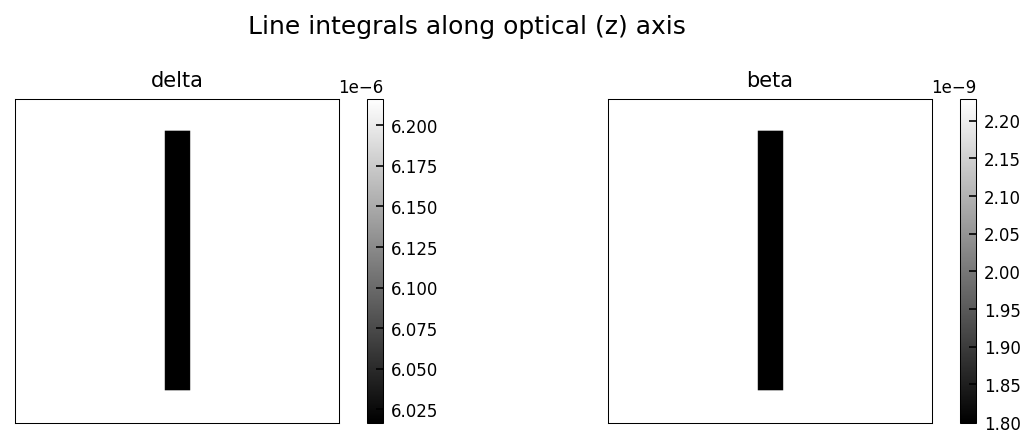

CPU times: user 4.02 s, sys: 1.21 s, total: 5.23 s
Wall time: 3.92 s


In [23]:
%%time

phantom_shape = jnp.array([Nz, N, N])
obj_delta, obj_beta = make_fiber_phantom(N, Nz, dx, fiber_width, energy, fiber_material=nylon, background_material=pmma)
show_phantom(obj_delta, obj_beta)

#### Visual

In [17]:
...

Ellipsis

#### Line Profile

In [18]:
...

Ellipsis